## Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

2025-10-22 15:56:12.854301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set data path and visualize some data

In [2]:
import pathlib

data_dir_train = pathlib.Path("../Data/animal_data/train/")
data_dir_test = pathlib.Path("../Data/animal_data/test/")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

1321


In [4]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

325


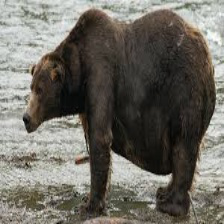

In [5]:
bears = list(data_dir_train.glob('Bear/*'))
PIL.Image.open(str(bears[0]))


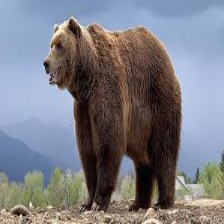

In [6]:
PIL.Image.open(str(bears[2]))

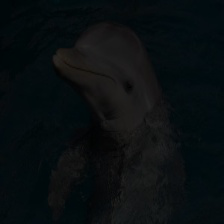

In [7]:
dolphins = list(data_dir_train.glob('Dolphin/*'))
PIL.Image.open(str(dolphins[0]))

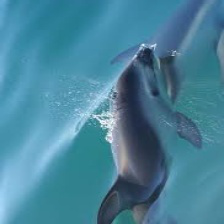

In [8]:
PIL.Image.open(str(dolphins[1]))

## Create the training, validation, and test datasets

In [10]:
batch_size = 32
img_height = 224
img_width = 224

In [51]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 1556 files belonging to 15 classes.
Using 1090 files for training.


In [52]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 1556 files belonging to 15 classes.
Using 466 files for validation.


In [17]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 388 files belonging to 15 classes.


In [18]:
class_names = train_ds.class_names
print(class_names)

['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


## Visualize the data

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)


2025-10-22 14:51:54.743172: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


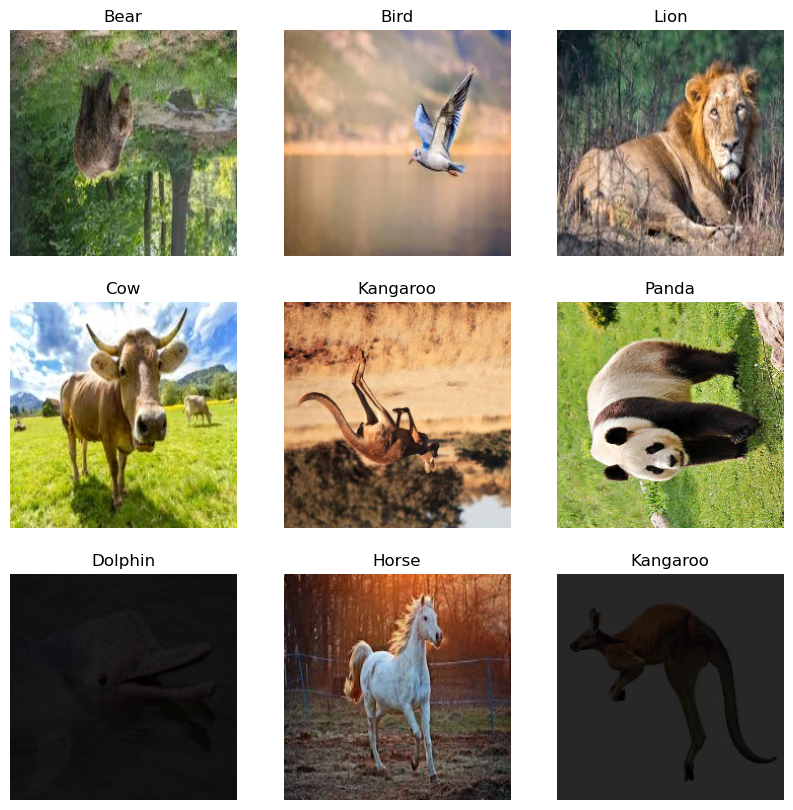

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    print(labels[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [32]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
def dataset_to_tensors(dataset):
    images = []
    labels = []
    for img, lbl in dataset.unbatch():
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

In [31]:
x_train, y_train = dataset_to_tensors(train_ds)
x_val, y_val = dataset_to_tensors(val_ds)
x_test, y_test = dataset_to_tensors(test_ds)

2025-10-22 16:02:21.861759: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-22 16:02:21.863793: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 749629440 exceeds 10% of free system memory.


In [32]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(1245, 224, 224, 3)
(1245, 15)
(311, 224, 224, 3)
(311, 15)
(388, 224, 224, 3)
(388, 15)


In [27]:
def dataset_split(ds):
    for image_batch, labels_batch in ds:
        X = image_batch
        y = labels_batch
    return X, y

In [28]:
X_train, y_train = dataset_split(train_ds)
X_val, y_val = dataset_split(val_ds)
X_test, y_test = dataset_split(test_ds)

2025-10-22 16:00:30.326890: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-22 16:00:30.487199: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(29, 224, 224, 3)
(29, 15)
(23, 224, 224, 3)
(23, 15)
(4, 224, 224, 3)
(4, 15)


## Standardize the data

In [33]:
normalization_layer = layers.Rescaling(1./255)

In [34]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))


## Create Keras model

#### Create the model

In [ ]:
num_classes = len(class_names)

model = Sequential()
model.add(Input(shape=(img_height, img_width, 3)))
model.add(Rescaling(1./255))
# model.add(Conv2D(16, 3, padding='same', activation='relu'))
# model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))

In [ ]:
# num_classes = len(class_names)

# model = Sequential([
#   layers.Input(shape=(img_height, img_width, 3)),
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

In [83]:
num_classes = len(class_names)

model = Sequential([
  layers.Input(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [84]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#### Model summary

In [85]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │    25,690,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,692,047 (98.01 MB)

 Trainable params: 25,692,047 (98.01 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [86]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 659ms/step - accuracy: 0.0763 - loss: 9.8588 - val_accuracy: 0.0772 - val_loss: 2.6764
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 617ms/step - accuracy: 0.1373 - loss: 2.6205 - val_accuracy: 0.1286 - val_loss: 2.6986
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 711ms/step - accuracy: 0.1414 - loss: 2.5581 - val_accuracy: 0.0868 - val_loss: 2.6076
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 696ms/step - accuracy: 0.1414 - loss: 2.5086 - val_accuracy: 0.1350 - val_loss: 2.5389
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 707ms/step - accuracy: 0.1912 - loss: 2.3787 - val_accuracy: 0.2283 - val_loss: 2.2975
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 626ms/step - accuracy: 0.3647 - loss: 2.0326 - val_accuracy: 0.3055 - val_loss: 2.0980
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 664ms/step - accuracy: 0.5141 - loss: 1.5322 - val_accuracy: 0.4373 - val_loss: 1.7865
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 629ms/step - accuracy: 0.7044 - loss: 1.0380 - val_accu

In [87]:
_, test_acc = model.evaluate(train_ds)
print(test_acc)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9558 - loss: 0.2822
0.9558233022689819


#### Visualize training results

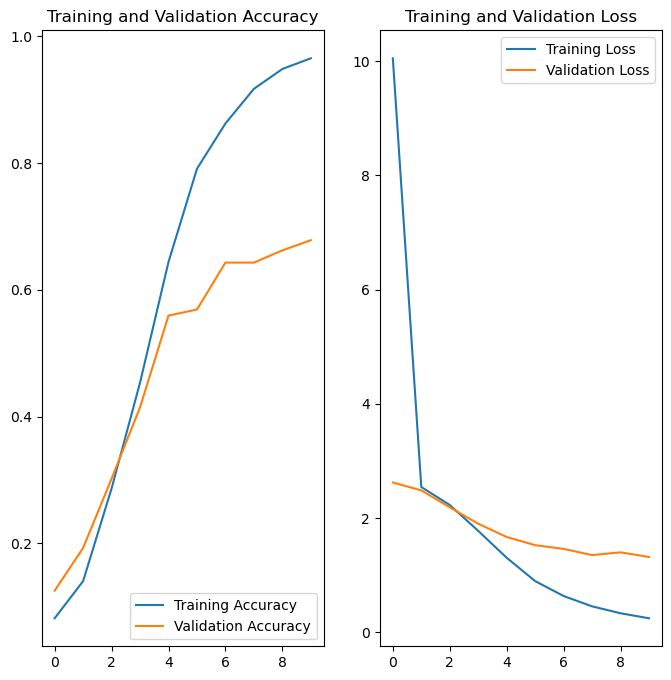

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Data augmentation

In [73]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [75]:
model2 = Sequential([
  layers.Input(shape=(img_height, img_width, 3)),
  data_augmentation, 
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [76]:
model2.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [77]:
model2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │    25,690,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,692,047 (98.01 MB)

 Trainable params: 25,692,047 (98.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 15
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 692ms/step - accuracy: 0.0586 - loss: 7.6919 - val_accuracy: 0.0740 - val_loss: 2.7109
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 667ms/step - accuracy: 0.0651 - loss: 2.7041 - val_accuracy: 0.0611 - val_loss: 2.7007
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 794ms/step - accuracy: 0.0731 - loss: 2.7009 - val_accuracy: 0.0804 - val_loss: 2.6952
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 808ms/step - accuracy: 0.0763 - loss: 2.6919 - val_accuracy: 0.0804 - val_loss: 2.6910
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 832ms/step - accuracy: 0.0859 - loss: 2.6723 - val_accuracy: 0.0772 - val_loss: 2.6881
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 757ms/step - accuracy: 0.0803 - loss: 2.6698 - val_accuracy: 0.0740 - val_loss: 2.6634
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 722ms/step - accuracy: 0.1076 - loss: 2.6444 - val_accuracy: 0.1093 - val_loss: 2.6522
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 719ms/step - accuracy: 0.1398 - loss: 2.6156 - val_accu

In [82]:
_, test_acc = model2.evaluate(train_ds)
print(test_acc)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.2040 - loss: 2.3625
0.2040160596370697


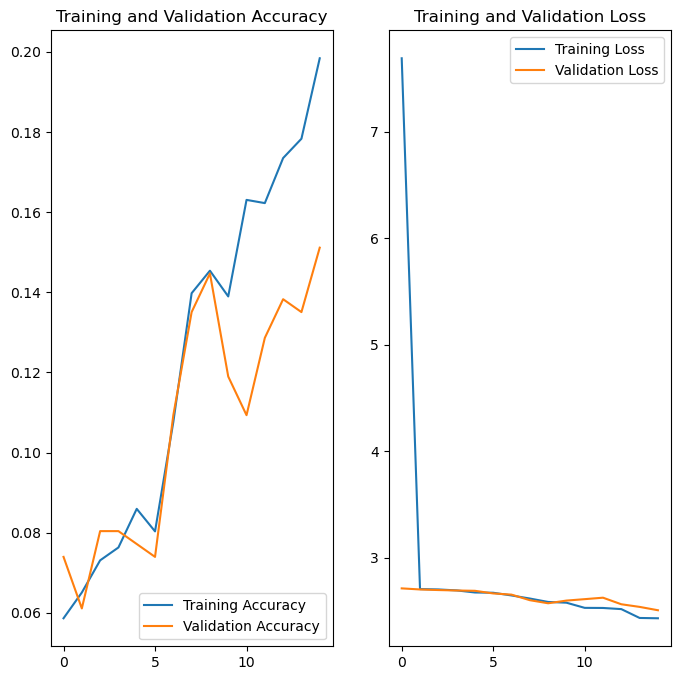

In [79]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Dropout

In [27]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### Compile and train the model

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 75s 399ms/step - accuracy: 0.4825 - loss: 1.4345 - val_accuracy: 0.4823 - val_loss: 1.2647
Epoch 2/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 75s 407ms/step - accuracy: 0.4886 - loss: 1.2514 - val_accuracy: 0.4796 - val_loss: 1.1896
Epoch 3/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 71s 384ms/step - accuracy: 0.4886 - loss: 1.2098 - val_accuracy: 0.4939 - val_loss: 1.1918
Epoch 4/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 380ms/step - accuracy: 0.4874 - loss: 1.1751 - val_accuracy: 0.4891 - val_loss: 1.1721
Epoch 5/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 380ms/step - accuracy: 0.4879 - loss: 1.1541 - val_accuracy: 0.4564 - val_loss: 1.1859
Epoch 6/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 88s 413ms/step - accuracy: 0.4893 - loss: 1.1278 - val_accuracy: 0.4877 - val_loss: 1.1544
Epoch 7/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 74s 402ms/step - accuracy: 0.4913 - loss: 1.1090 - val_accuracy: 0.4864 - val_loss: 1.1178
Epoch 8/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 72s 390ms/step - accuracy: 0.4918 - loss: 1

#### Visualize training results

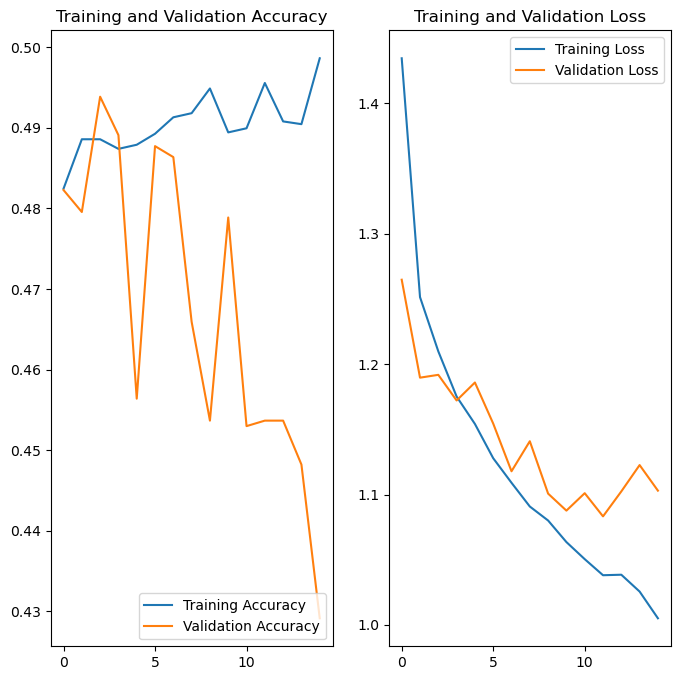

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Transfer model

In [39]:
from keras.applications.vgg16 import VGG16

# Création du modèle VGG-16 implementé par Keras
model = VGG16() 

In [40]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img('../Data/animal_data/test/Dog/Dog_12_1.jpg', target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

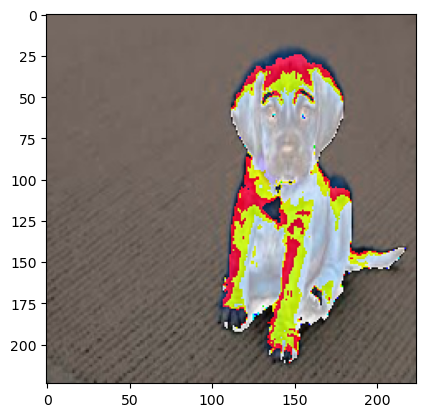

In [41]:
plt.imshow(img[0,:,:,:].astype("uint8"))

In [42]:
y = model.predict(img) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


In [43]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

Top 3 : [('n02087394', 'Rhodesian_ridgeback', np.float32(0.29143986)), ('n02088466', 'bloodhound', np.float32(0.23496325)), ('n02108422', 'bull_mastiff', np.float32(0.1787629))]


In [46]:
from keras import Model
num_classes = len(class_names)


# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in model.layers:
   layer.trainable = False

# Récupérer la sortie de ce réseau
x = model.output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

In [47]:
new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │       401,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,116,367 (57.66 MB)

 Trainable params: 401,679 (1.53 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [53]:
# Compiler le modèle 
epochs = 3
new_model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), 
                  metrics=["accuracy"])

# Entraîner sur les données d'entraînement 
model_info = new_model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=batch_size, verbose=2)

Epoch 1/3
35/35 - 195s - 6s/step - accuracy: 0.0743 - loss: 2.6920 - val_accuracy: 0.0665 - val_loss: 2.6935
Epoch 2/3
35/35 - 196s - 6s/step - accuracy: 0.0817 - loss: 2.7018 - val_accuracy: 0.0773 - val_loss: 2.6700
Epoch 3/3
35/35 - 180s - 5s/step - accuracy: 0.0817 - loss: 2.6840 - val_accuracy: 0.0901 - val_loss: 2.6405


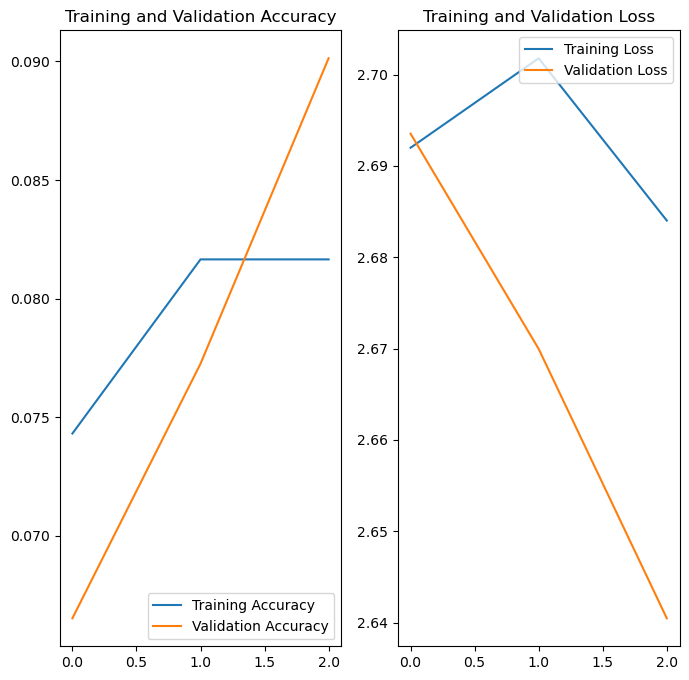

In [54]:
acc = model_info.history['accuracy']
val_acc = model_info.history['val_accuracy']

loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
print(f"Model valid accuracy: {new_model.evaluate(val_ds)[1]*100.:.3f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.0901 - loss: 2.6405
Model valid accuracy: 9.013


In [56]:
print(f"Model test accuracy: {new_model.evaluate(test_ds)[1]*100.:.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.1005 - loss: 2.6595
Model test accuracy: 10.052


In [78]:
def display_predictions(dataset, model, class_names):
     
    plt.figure(figsize=(20,20))
    num_rows = 8
    num_cols = 8
    jdx = 0
     
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset.take(2):
         
        # print(image_batch.shape)
         
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
         
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = tf.argmax(labels_batch[idx]).numpy()

            # print(pred_idx)
            # print(truth_idx)
             
            # Set the title color based on the prediction.
            if pred_idx == truth_idx:
                color='g'
            else:
                color='r'
                 
            jdx += 1
                 
            if jdx > num_rows*num_cols:
                # Break from the loops if the maximum number of images have been plotted
                break
                 
            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])
                 
            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx].numpy().astype("uint8"));
    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


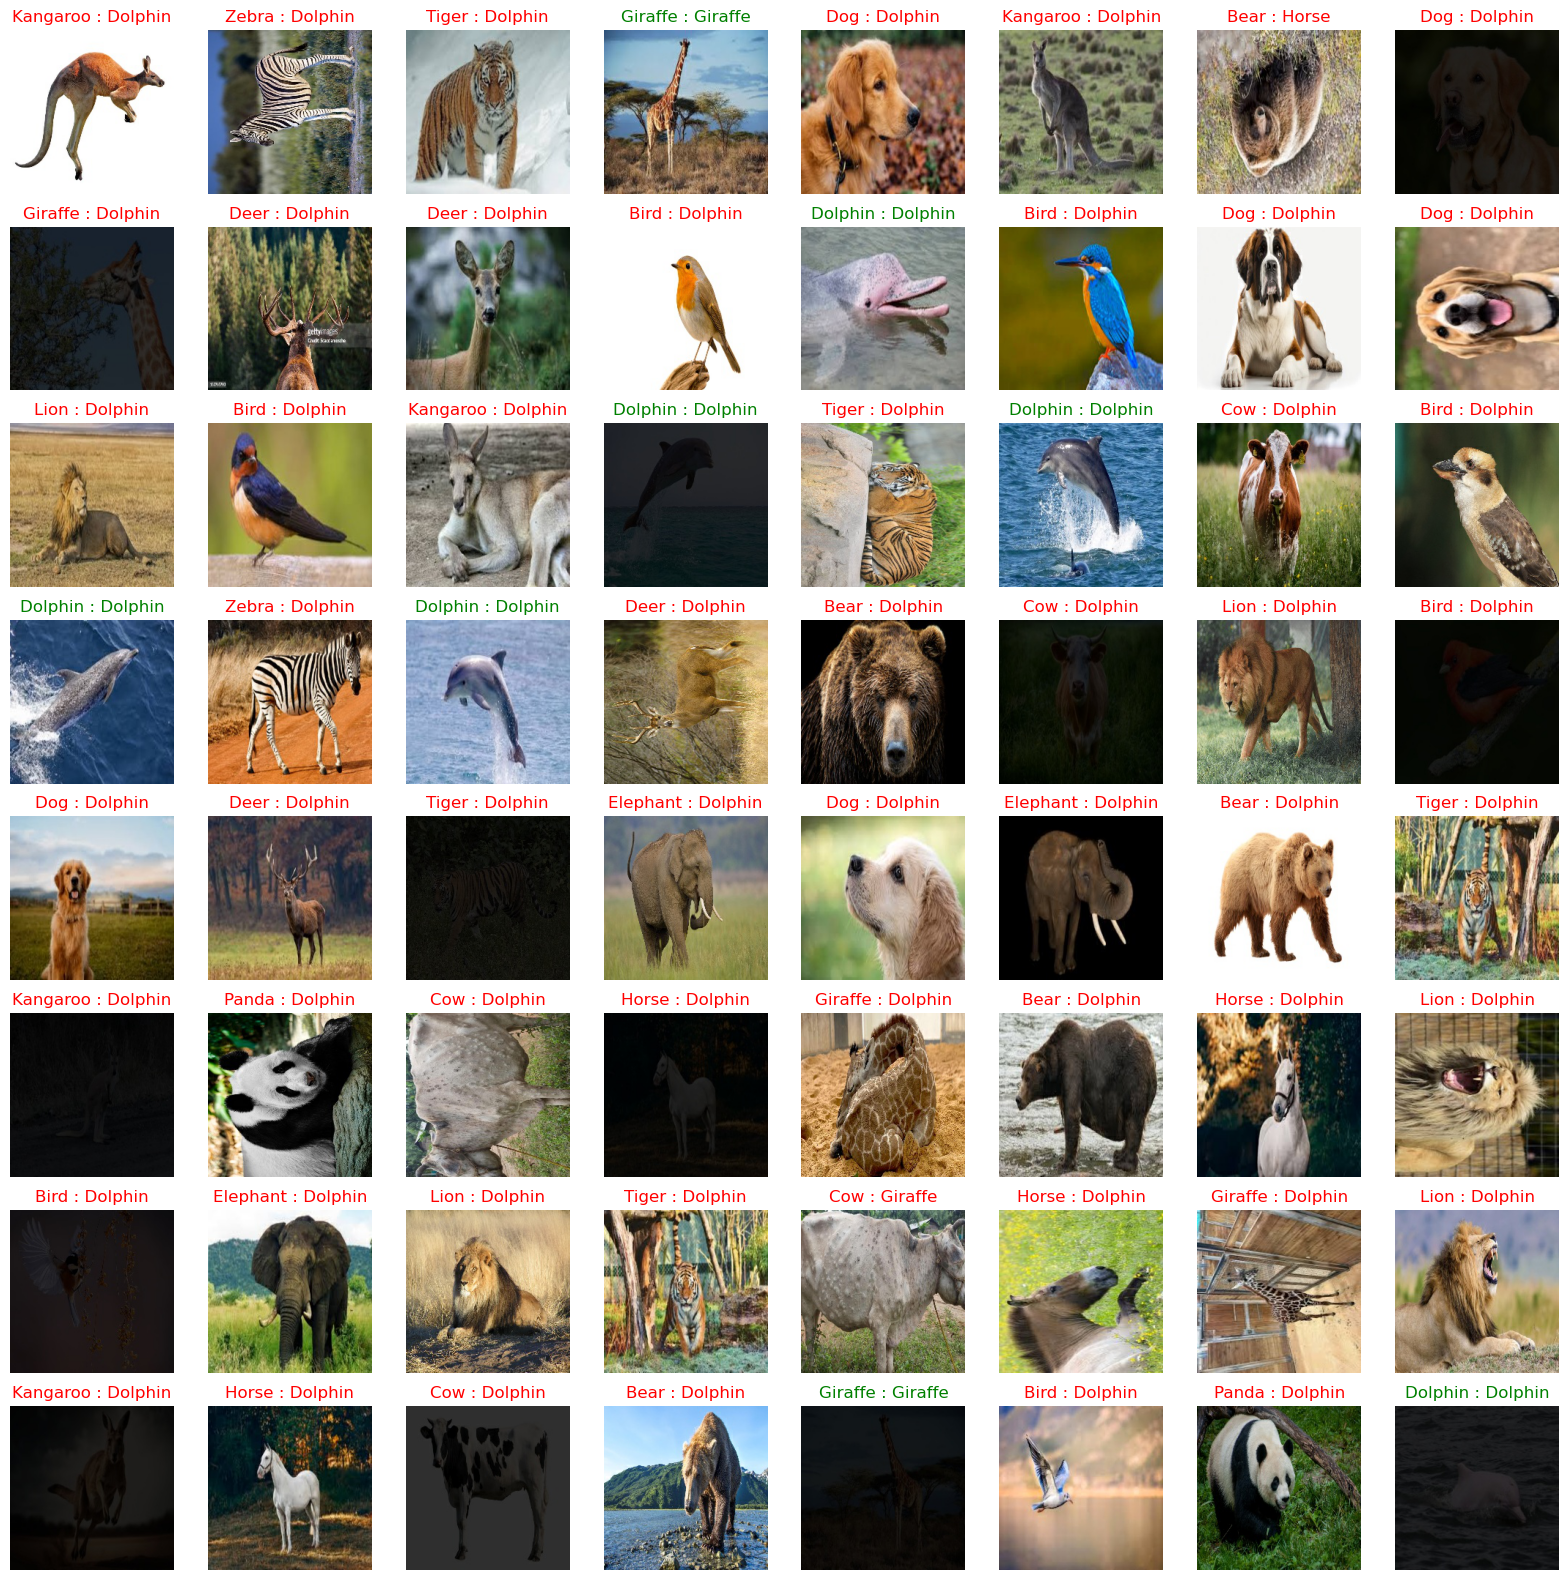

In [79]:
display_predictions(test_ds, new_model, class_names)

#### Predict on new data

In [ ]:
img = load_img('../Data/animal_data/test/Cow/Cow_1_2.jpg', target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

predictions = model.predict(img)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
This image most likely belongs to sunflowers with a 47.78 percent confidence.
